In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'analog-foundry-466522-c7')

## Capitulo 7 - Time Series Smoothing and Filtering

Smoothing a time series reoes certain frequencies or components to gain insight into the underlying structure of time series. For example , we want remove noise to emphasize the signal in the time series before we begin our analysis Think of the famous saying 'garbage in, garbage out'.

Data smoothing is nothing more than avareging data points with their neghbors in a time series, resulting in a blur of sharp edges in our time series. Therefore, data smoothing is siilar to filtering, where high frequencies are suppresed to extract low-frequency  signals. In doing so, we generate a new smoothed data point for each data point in time series.

To smoooth our time series, we can choose between different approaches, which mainly differ in how the mean aroud a data point is calculates. The most commonly used approaches are:

- Moving average
- Kernel Smoothing
- (Single, Double, Triple) Exponential Smoothing

Which approach we choose depends on the amount of noise and the compoennts, such as trend seasonality, in our time sereis


## Moving statistics

Moving or continuous statistics are computed by sliding a window of a given size over the original time series and aggregating the data for each window. This is also known as convolution over time index. The two important parameters of the convolution operation are the window size and the stride length. The former defines the number of time units taken as input to the aggregate function, while the latter defines the gap over the time index between each computation. For example, suppose a window size of k and a stride length l are used to compute the function f over a time series x1,x2, ... ,xn having N observations. In this scenario, the moving statistic is obtained as f(x1,x2, ... ,xt), f(x1+l,x2+l, ... ,xt+l) and so on. Note that each time the function is computed by shifting the time window to the right by l time units.

### Moving Average

The moving averageThe Moving Average is the easiest approach we can use. Within a fixed-length Sliding Window, all data points are averaged with the same weighting.

The approach is well suited for data with little noise and for highlighting long-term trends. However, the Moving Average cannot capture seasonality and should therefore not be used for time series with complex seasonality and non-linearity. Furthermore, the approach cannot calculate values ​​at the beginning and/or end of the time series, depending on whether a one-sided or two-sided Moving Average is calculated.

The Sliding Window is placed around a data point and the values ​​within the window are averaged before the window is slid to the next data point. This is repeated until the time series is smoothed. The degree of smoothing is determined by the width of the Sliding Window. The wider the window, the stronger the smoothing.

In [ ]:
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geemap


In [ ]:
ee.Authenticate()
ee.Initialize(project='analog-foundry-466522-c7')

In [ ]:
coordinates = np.array([ 23.5544698, 40.025684])
x = float(coordinates[0])
y = float(coordinates[1])

In [ ]:
date_start = '2005-01-01'
date_end = '2010-01-01'

Pegando as temperaturas do ar atraves do database do ERA5

In [ ]:
location_point = ee.Geometry.Point(x, y)
gre = ee.ImageCollection('ECMWF/ERA5/DAILY').select('mean_2m_air_temperature').filter(ee.Filter.date(date_start, date_end))

In [ ]:
data = gre.getRegion(location_point, 27831).getInfo() #Extrai os valores de pixel da coleção de imagens dentro de uma regiao especificada
data = pd.DataFrame(data, columns = data[0]) #Cria um dataframe
data = data.drop(0, axis = 0)#Estamos removendo uma linha do nosso dataset, pois ela contem o nome das colunas presente no dataset./

In [ ]:
#Vamos printar o dataframe
data['mean_2m_air_temperature']=data['mean_2m_air_temperature'].astype('float')
data['mean_2m_air_temperature']=data['mean_2m_air_temperature'].apply(lambda x: x-273)
data['date'] = pd.to_datetime(data['id'], format='%Y%m%d')
data.set_index("date", inplace=True)
data.head()

id  longitude   latitude           time  \
date                                                        
2005-01-01  20050101  23.625957  40.126625  1104537600000   
2005-01-02  20050102  23.625957  40.126625  1104624000000   
2005-01-03  20050103  23.625957  40.126625  1104710400000   
2005-01-04  20050104  23.625957  40.126625  1104796800000   
2005-01-05  20050105  23.625957  40.126625  1104883200000   

            mean_2m_air_temperature  
date                                 
2005-01-01                 7.851562  
2005-01-02                 7.653076  
2005-01-03                 7.288391  
2005-01-04                 7.175964  
2005-01-05                 9.686920

In [ ]:
data = data.drop(columns = ['id', 'longitude', 'latitude', 'time'])

In [ ]:
data.head()

mean_2m_air_temperature
date                               
2005-01-01                 7.851562
2005-01-02                 7.653076
2005-01-03                 7.288391
2005-01-04                 7.175964
2005-01-05                 9.686920

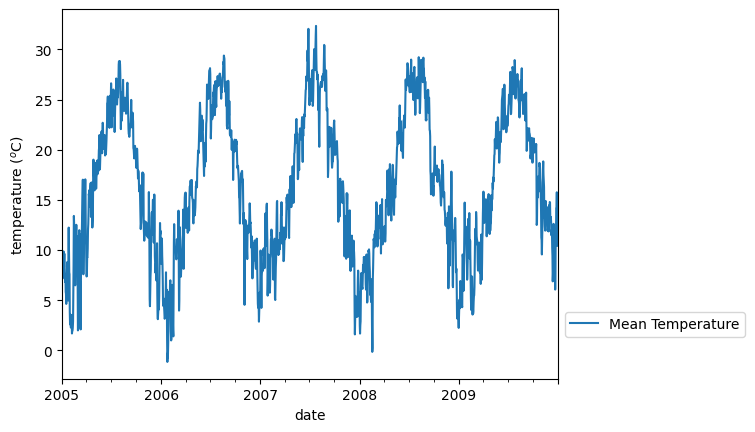

In [ ]:
import matplotlib.pyplot as plt

data.mean_2m_air_temperature.plot(label='Mean Temperature')
plt.ylabel('temperature ($^o$C)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.2))

In [ ]:
# Este código aplica uma média móvel semanal e uma média móvel mensal aos dados de temperatura.
weekly_moving_average = data['mean_2m_air_temperature'].rolling(7).mean()
monthly_moving_average = data['mean_2m_air_temperature'].rolling(30).mean()

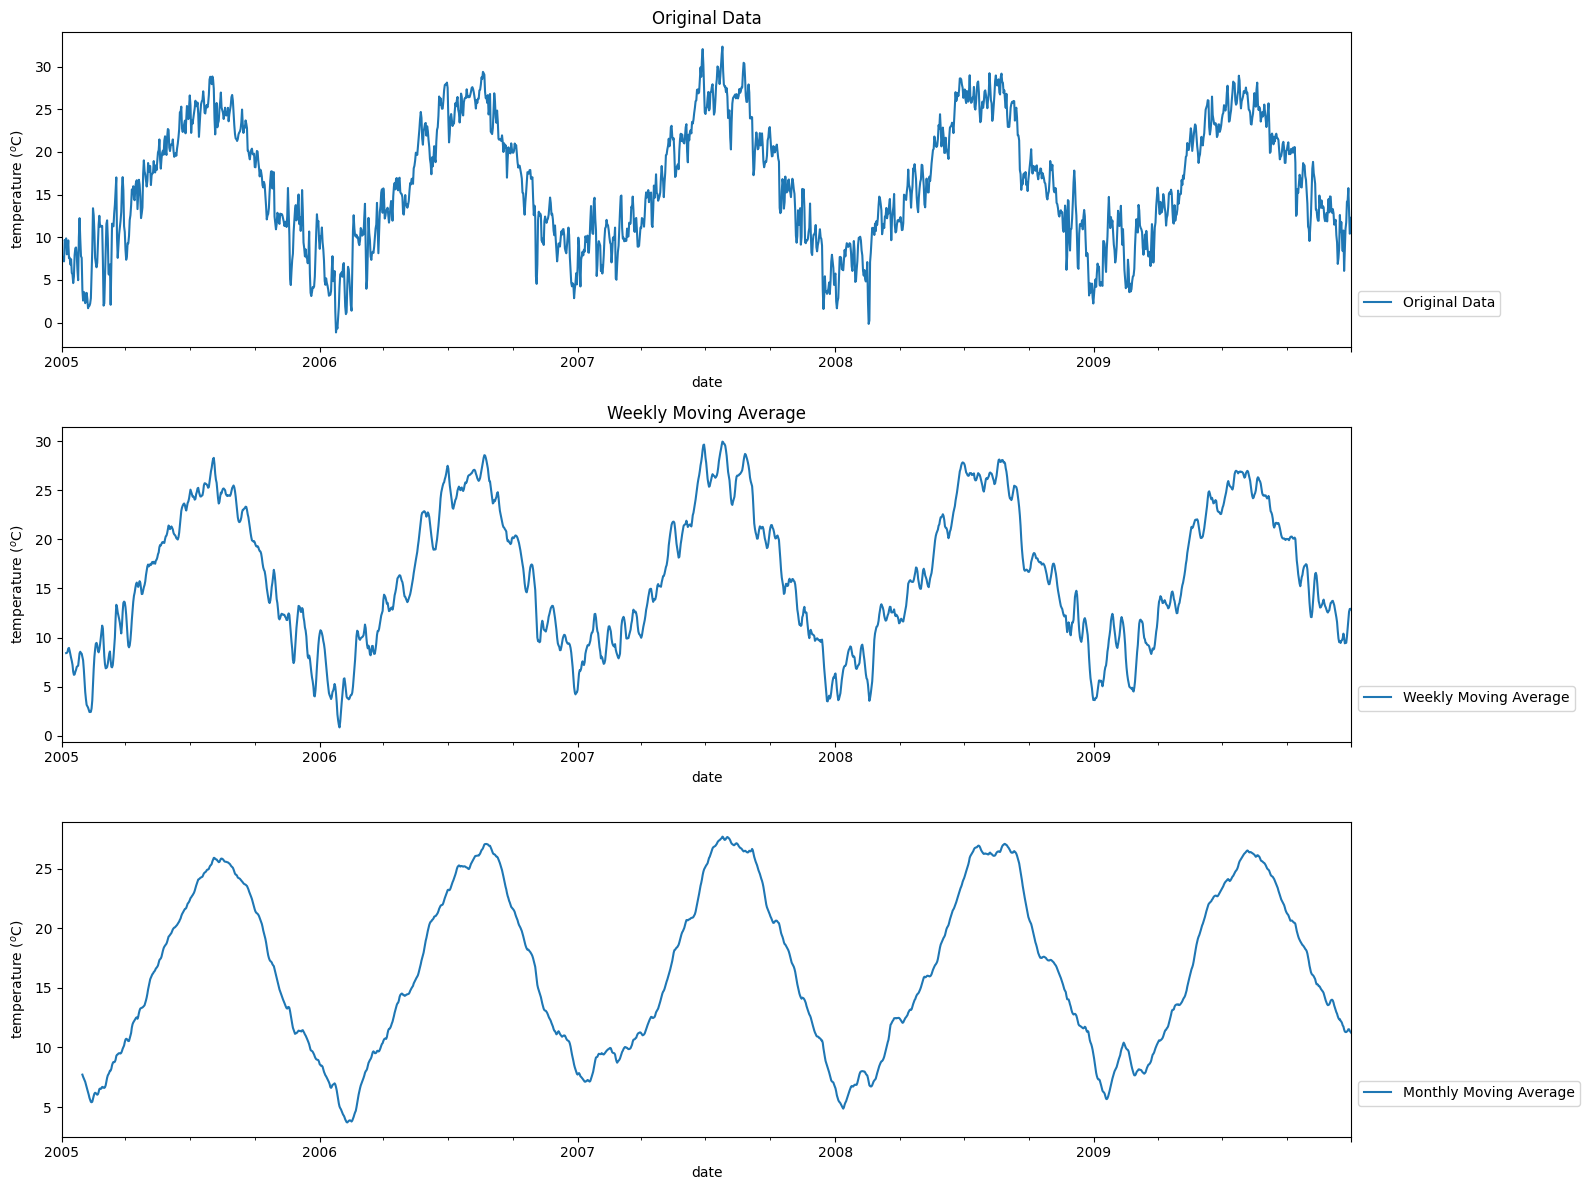

In [ ]:
#Vamos usar o matplotlib para printar essas duas transformações
plt.figure(figsize = (16,12))
plt.subplot(3, 1, 1)
data['mean_2m_air_temperature'].plot(label = 'Original Data')
plt.ylabel('temperature ($^o$C)')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.2))
plt.title('Original Data')

plt.subplot(3,1, 2)
weekly_moving_average.plot(label = 'Weekly Moving Average')
plt.ylabel('temperature ($^o$C)')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.2))
plt.title('Weekly Moving Average')

plt.subplot(3, 1 ,3)
monthly_moving_average.plot(label = 'Monthly Moving Average')
plt.ylabel('temperature ($^o$C)')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.2))

plt.tight_layout()
plt.show()

## Kernel Smoothing

Kernel smoothing is very similar to Moving Average. The only difference is that we use differents weightsfor the average in Sliding Window. The weihjts depend on the format of the kernel function. Due to similarity with Moving Average, the advantages and disadvantage are also similar

The widht of the sliding window can be defined based on the Full Width at at Half Maximum(FWHM). This cuts off the tails of the kernel that have values less than half the maximum height of the curve.

Often, a Gaussian Kernel is used, which represents a Gaussian distribution. This gives a higher weight to data points that are close to the data point around which we want to smooth the time series

## Gaussian Kernel

Kernels define the shape of the function used to average neighboring points. The gaussian kernel has the shpae of the gaussian curve. The gaussian curve has the following shape.

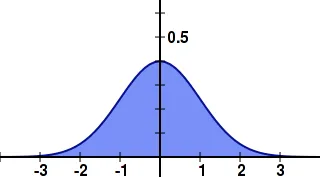

As seen in the Gaussian curve, points close to (around 0 on the curve above) will have higher weighting and points further away will have lower weighting.

In [ ]:
from re import S
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_smoothing(data, sigma = 1):
  smoothed_data = gaussian_filter1d(data, sigma = sigma)
  return smoothed_data

#Exemplo assumindo que o dataset ja esta pronto
data['smoothed_temperature'] = apply_gaussian_smoothing(data['mean_2m_air_temperature'], sigma = 7) #Ajuste de sigma é ncessario

Text(0.5, 1.0, 'Gaussian Smoothing Average')

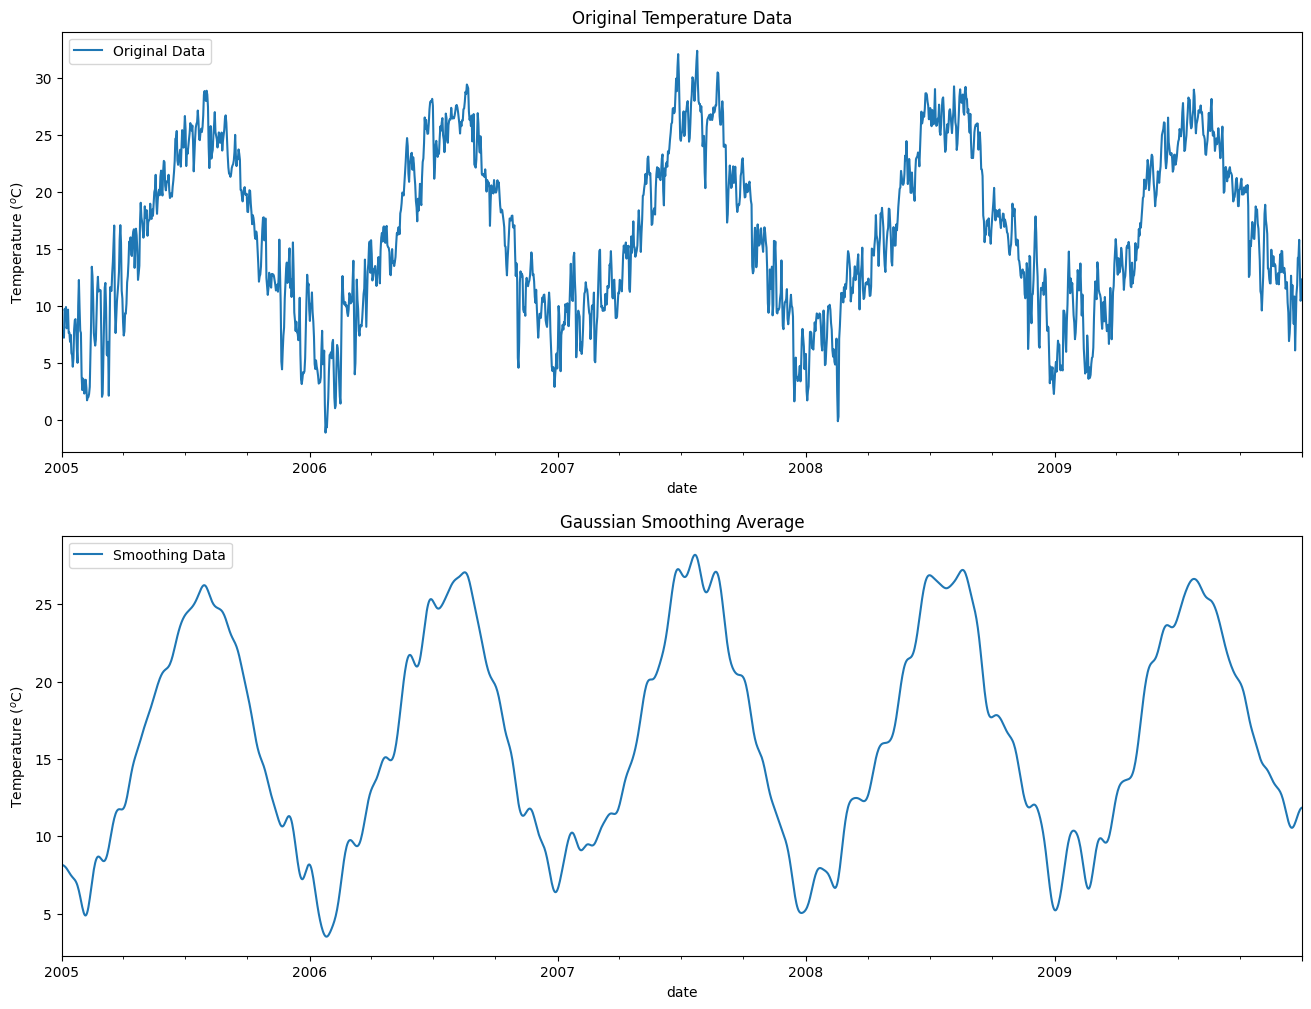

In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
data['mean_2m_air_temperature'].plot(label='Original Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Original Temperature Data')

plt.subplot(2, 1, 2)
data['smoothed_temperature'].plot(label='Smoothing Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Gaussian Smoothing Average')


## Exponential Smoothing

Since moving average and kernel smoothing cannot capture complex non-linearity and cannot calculate values at the beginning and/or end of the time series, Exponential Smoothing was developed.

Here, all past observations are weihjted based on an exponentially decreasing function. For this, no Slideing Window is used and more recent data points are given a higher weight than those back in the past.

Similar to moving average and kernel smoothing, a challenging part of smoothing is choosing the right smoothing factors and model hyperparemters. This can be done manually or throuh optimization.

We can choose between threee types, which differ in which components of the time series they can handle: Single, Double, and triple exponential smoothing. Below, the three types are ordered by their complexity, startingwith the simplest



## Simple Exponential hoothing

Single expoential smoothing can be used for stationary time series that do not have a trend or seasonality.
Smoothing is controlled by a smoothing factor alpha. The smoohting facetor can vary between 0 and 1 and controls the exponential decay of the weight. The higher the smoothing factor, the lower the weight for past data points and threfore the lower the smoothing;

In [ ]:
path = '/content/drive/MyDrive/AlvaroSampaio/GeoScan/Global Temperature.csv'
df = pd.read_csv(path)
df.head()

Year   Month  Monthly Anomaly  Monthly Unc.   Annual Anomaly  Annual Unc  \
0  1850       1           -0.801         0.482              NaN         NaN   
1  1850       2           -0.102         0.592              NaN         NaN   
2  1850       3           -0.119         0.819              NaN         NaN   
3  1850       4           -0.485         0.575              NaN         NaN   
4  1850       5           -0.351         0.549              NaN         NaN   

  Five-Year Anomaly  Five-Year Unc.  Ten-Year Anomaly  Ten-Year Unc.  \
0               NaN             NaN               NaN            NaN   
1               NaN             NaN               NaN            NaN   
2               NaN             NaN               NaN            NaN   
3               NaN             NaN               NaN            NaN   
4               NaN             NaN               NaN            NaN   

    Twenty-Year Anomaly  Twenty-year Unc.  
0                   NaN               NaN  
1                   NaN               NaN  
2                   NaN               NaN  
3                   NaN               NaN  
4                   NaN               NaN

In [ ]:
df.rename(columns = {'Month	' : 'Month'}, inplace = True)

In [ ]:
df.head()

Year   Month  Monthly Anomaly  Monthly Unc.   Annual Anomaly  Annual Unc  \
0  1850       1           -0.801         0.482              NaN         NaN   
1  1850       2           -0.102         0.592              NaN         NaN   
2  1850       3           -0.119         0.819              NaN         NaN   
3  1850       4           -0.485         0.575              NaN         NaN   
4  1850       5           -0.351         0.549              NaN         NaN   

  Five-Year Anomaly  Five-Year Unc.  Ten-Year Anomaly  Ten-Year Unc.  \
0               NaN             NaN               NaN            NaN   
1               NaN             NaN               NaN            NaN   
2               NaN             NaN               NaN            NaN   
3               NaN             NaN               NaN            NaN   
4               NaN             NaN               NaN            NaN   

    Twenty-Year Anomaly  Twenty-year Unc.  
0                   NaN               NaN  
1                   NaN               NaN  
2                   NaN               NaN  
3                   NaN               NaN  
4                   NaN               NaN

In [ ]:
#padronizando as datas
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df.Year.astype(str) + '/' + df.Month.astype(str) + '/01')

In [ ]:
df.set_index('Date', inplace = True)

In [ ]:
#Vamos selecionar a partir da data de 1900
df_1900 = df[:'1900'].copy()

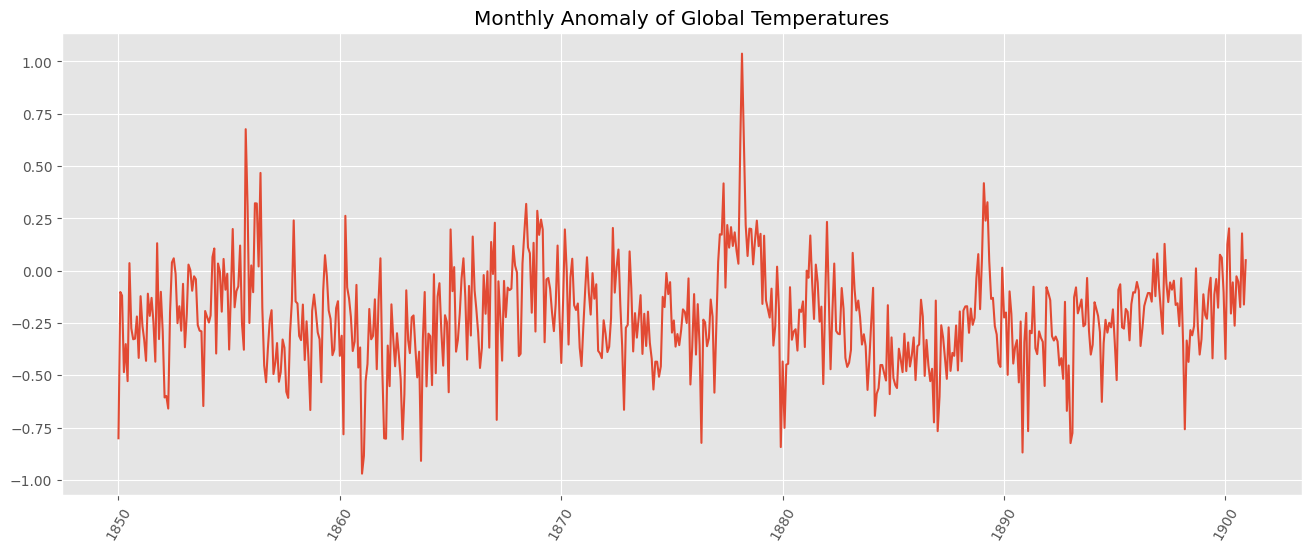

In [ ]:
plt.figure(figsize = (16 , 6))
plt.style.use('ggplot')
plt.plot(df_1900.index, df_1900['Monthly Anomaly'])
plt.title('Monthly Anomaly of Global Temperatures')
plt.xticks(rotation = 60)
plt.show()

In [ ]:
import statsmodels

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing
smoother = SimpleExpSmoothing(df_1900['Monthly Anomaly'])
smoothed_time_series = smoother.fit(smoothing_level = 0.1, optimized = False).fittedvalues

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'Exponential Smoothing Average')

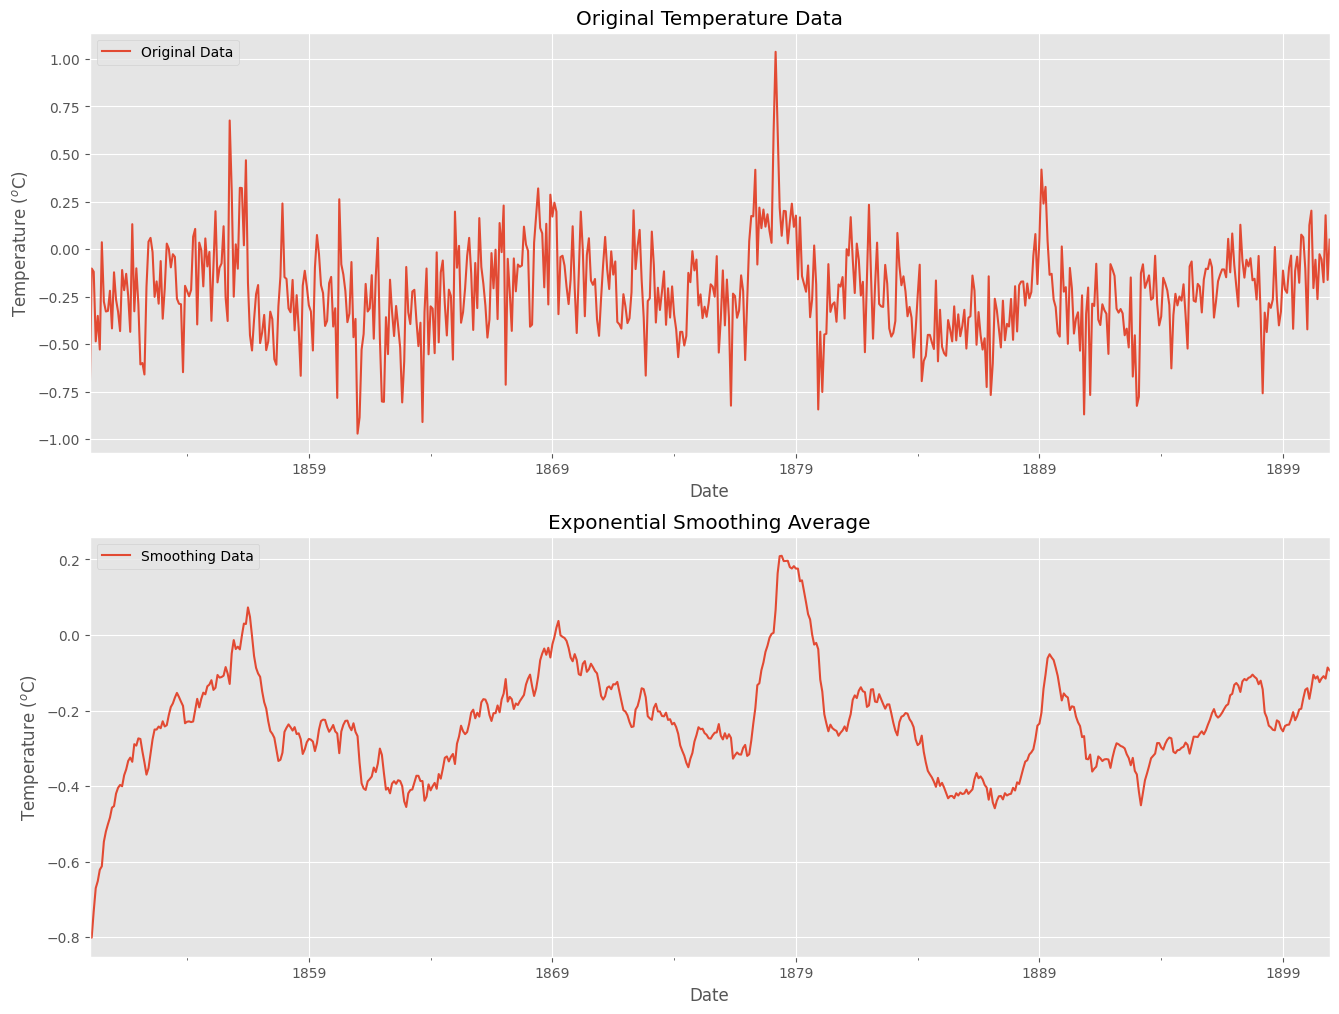

In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
df_1900['Monthly Anomaly'].plot(label='Original Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Original Temperature Data')

plt.subplot(2, 1, 2)
smoothed_time_series.plot(label='Smoothing Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Exponential Smoothing Average')

### Double Exponential Smoothing

Double Exponential Smoothing extends Single Exponential Smoothing by repeating the smoothing. This allows the trend of a time series to be captured while the seasonality is not captured.

To achieve this, another smoothing factor β is added that controls the smoothing of the trend. Similar to α, β can range between 0 and 1 and controls the exponential decay of the weights.

Since the trend can be additive (i.e. a linear trend) or multiplicative (i.e. an exponential trend), smoothing and its implementation in Python differ slightly. Therefore, before we apply Double Exponential Smoothing, we need to identify what type of trend is present in the time series.

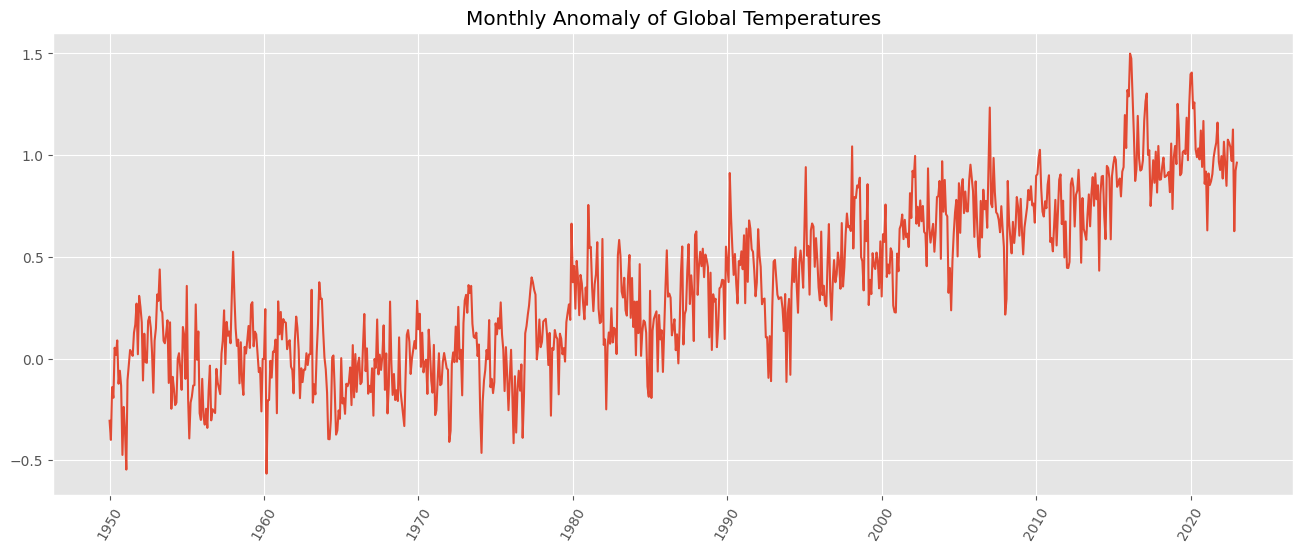

In [ ]:
df_1950 = df['1950':].copy()
plt.figure(figsize=(16,6))
plt.style.use("ggplot")
plt.plot(df_1950.index, df_1950['Monthly Anomaly'])
plt.title('Monthly Anomaly of Global Temperatures')
plt.xticks(rotation=60)
plt.show()

In [ ]:
from statsmodels.tsa.api import Holt
smoother = Holt(df_1950['Monthly Anomaly'])
smoothed_double_exp = smoother.fit(smoothing_level = 0.2, smoothing_slope = 0.02, optimized = False).fittedvalues

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-3131258730.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  smoothed_double_exp = smoother.fit(smoothing_level = 0.2, smoothing_slope = 0.02, optimized = False).fittedvalues


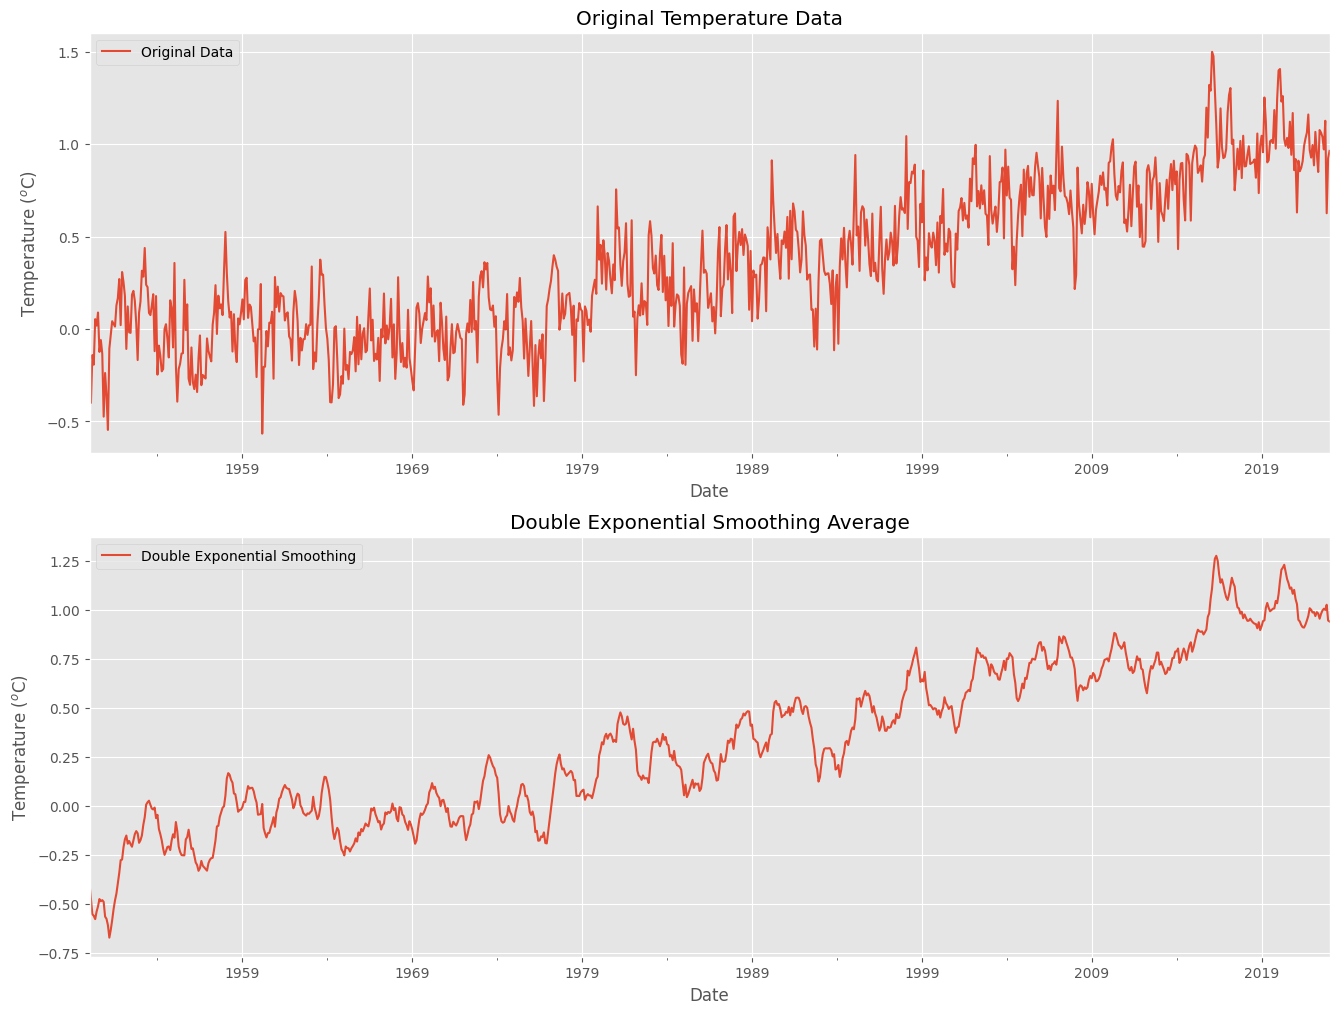

In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
df_1950['Monthly Anomaly'].plot(label='Original Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Original Temperature Data')

plt.subplot(2, 1, 2)
smoothed_double_exp.plot(label='Double Exponential Smoothing')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Double Exponential Smoothing Average')
plt.show()

### Triple Exponential Smoothing

Triple Exponential Smoothing is the most sophisticated exponential smoothing method. The method can capture both the trend and seasonality of a time series. The approach is also called Holt-Winters Exponential Smoothing.

For this, another smoothing factor γ is added to capture seasonality. Similar to trend, seasonality can be additive or multiplicative.


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
smoother = ExponentialSmoothing(df_1950['Monthly Anomaly'])
smoothed_triple_exp = smoother.fit(smoothing_level=0.2, smoothing_trend=0.02, smoothing_seasonal=0.1, optimized=False).fittedvalues

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


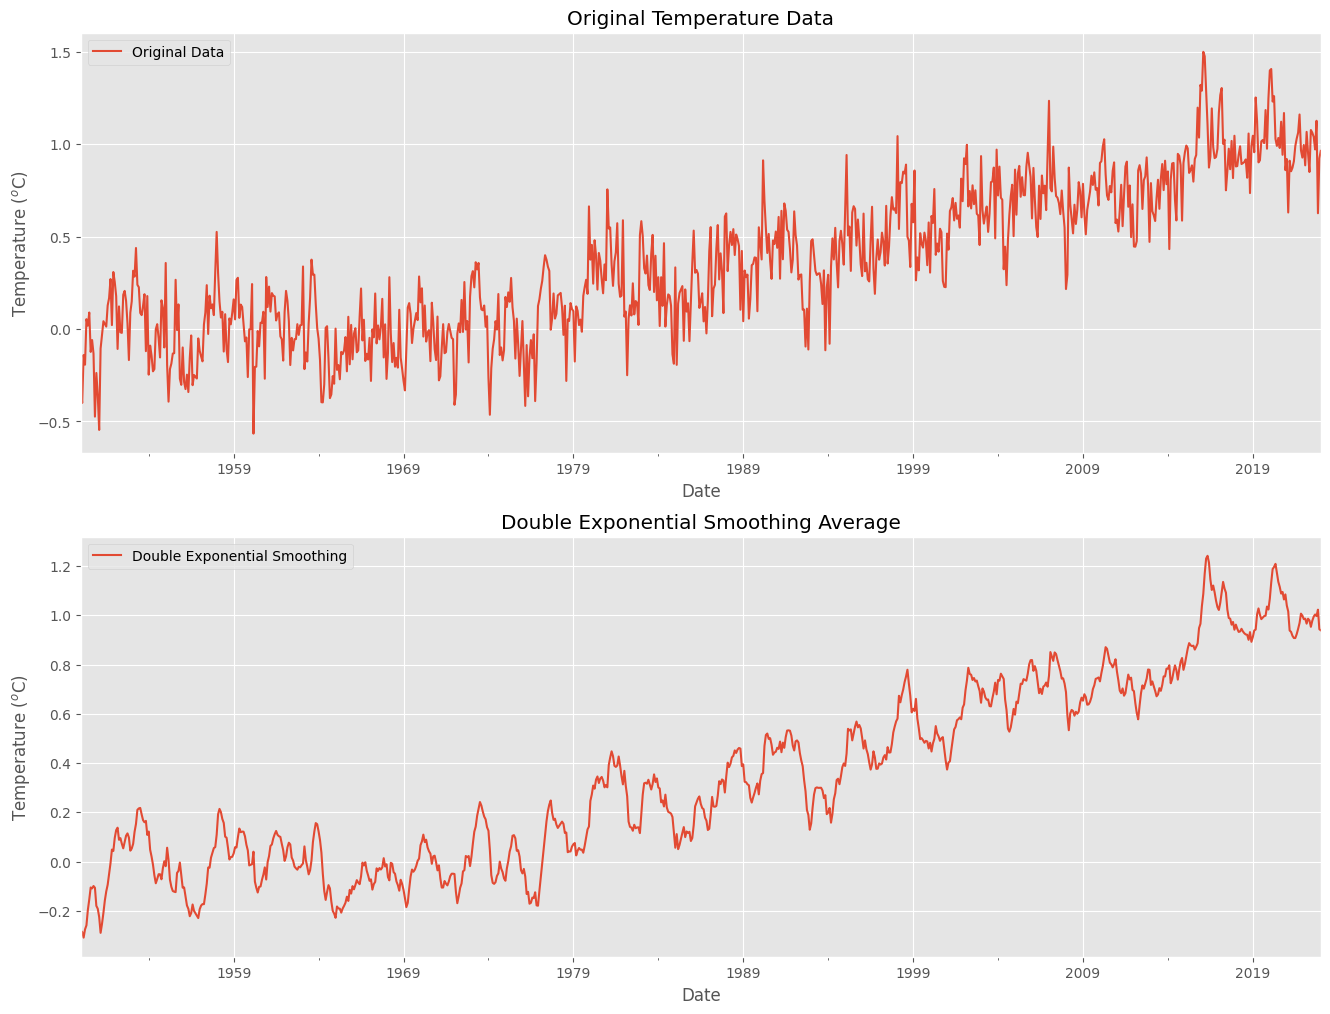

In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
df_1950['Monthly Anomaly'].plot(label='Original Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Original Temperature Data')

plt.subplot(2, 1, 2)
smoothed_triple_exp.plot(label='Double Exponential Smoothing')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Double Exponential Smoothing Average')
plt.show()

### Convolution Filters

Convolutional smoothing is a technique used to smooth time series data by applying a mathematical function within a sliding window. The following are the different types of windows used in convolutional smoothing:

- Constant/Unitary Window: Each point in the window has an equal weight.
- Hanning Window: Weights are calculated using a cosine function, giving more weight to points in the middle of the window.
- Hamming Window: Similar to the Hanning window, but with weight calculations adjusted to minimize disturbances.
- Bartlett Window: A triangle-shaped window, with weights decreasing linearly towards the center.
- Blackman Window: Uses cosine functions to enhance frequency component analysis.


In [ ]:
!pip install tsmoothie

In [ ]:
from tsmoothie.smoother import ConvolutionSmoother

In [ ]:
#Vamos aplicar smoothing com kernels convolucionais to para datas de 1950
Smoother = ConvolutionSmoother(window_len = 20, window_type = 'ones')
Smoother.smooth(df_1950 ['Monthly Anomaly'])
df_1950['Conv Smooth Monthly Anomaly'] = Smoother.smooth_data[0]


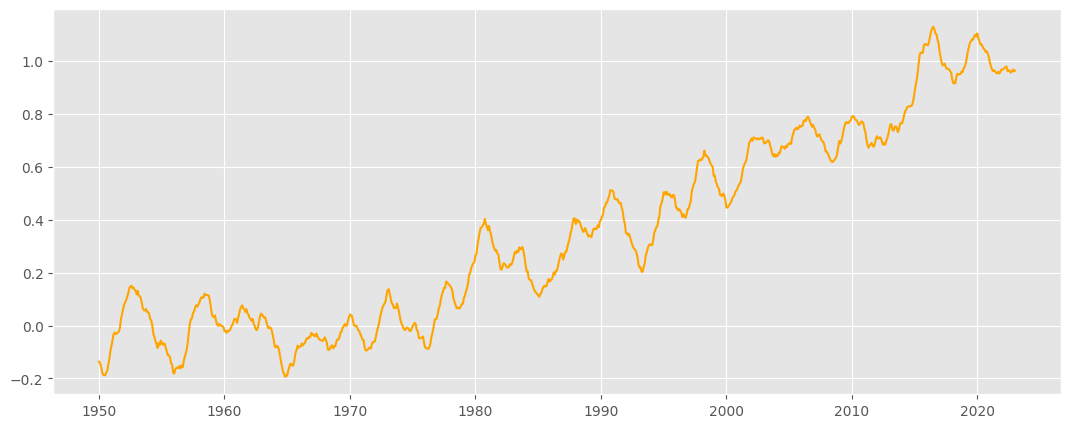

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(df_1950['Conv Smooth Monthly Anomaly'], c='orange')

## Kalman Filter

Kalman filtering is a technique used to estimate how a data point in a series envolves over time, even when the measurements are noisy. It predicts the next state basedd on a model and then refines the prediction using actual measurements. This process consists of two main steps : predicing the state and then correcting it. By doin this, Kalman filtering reduces measurement error and makes estimates more accurate

In [ ]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 14.1 MB/s eta 0:00:00


In [ ]:
from pykalman import KalmanFilter

In [ ]:
#After instalfing the library and important the function we can apply Kalman Filter to our data

In [ ]:
data = df_1950['Monthly Anomaly'].values

In [ ]:
#Inicializando o filtro de kalman
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = data[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance = 0.01)

#Estimate the state sequence using the kalman filter
kalman_filter, _ = kf.filter(data)
#Add the kalman smoothd data to the dataframe
df_1950['Kalman_filter'] = kalman_filter

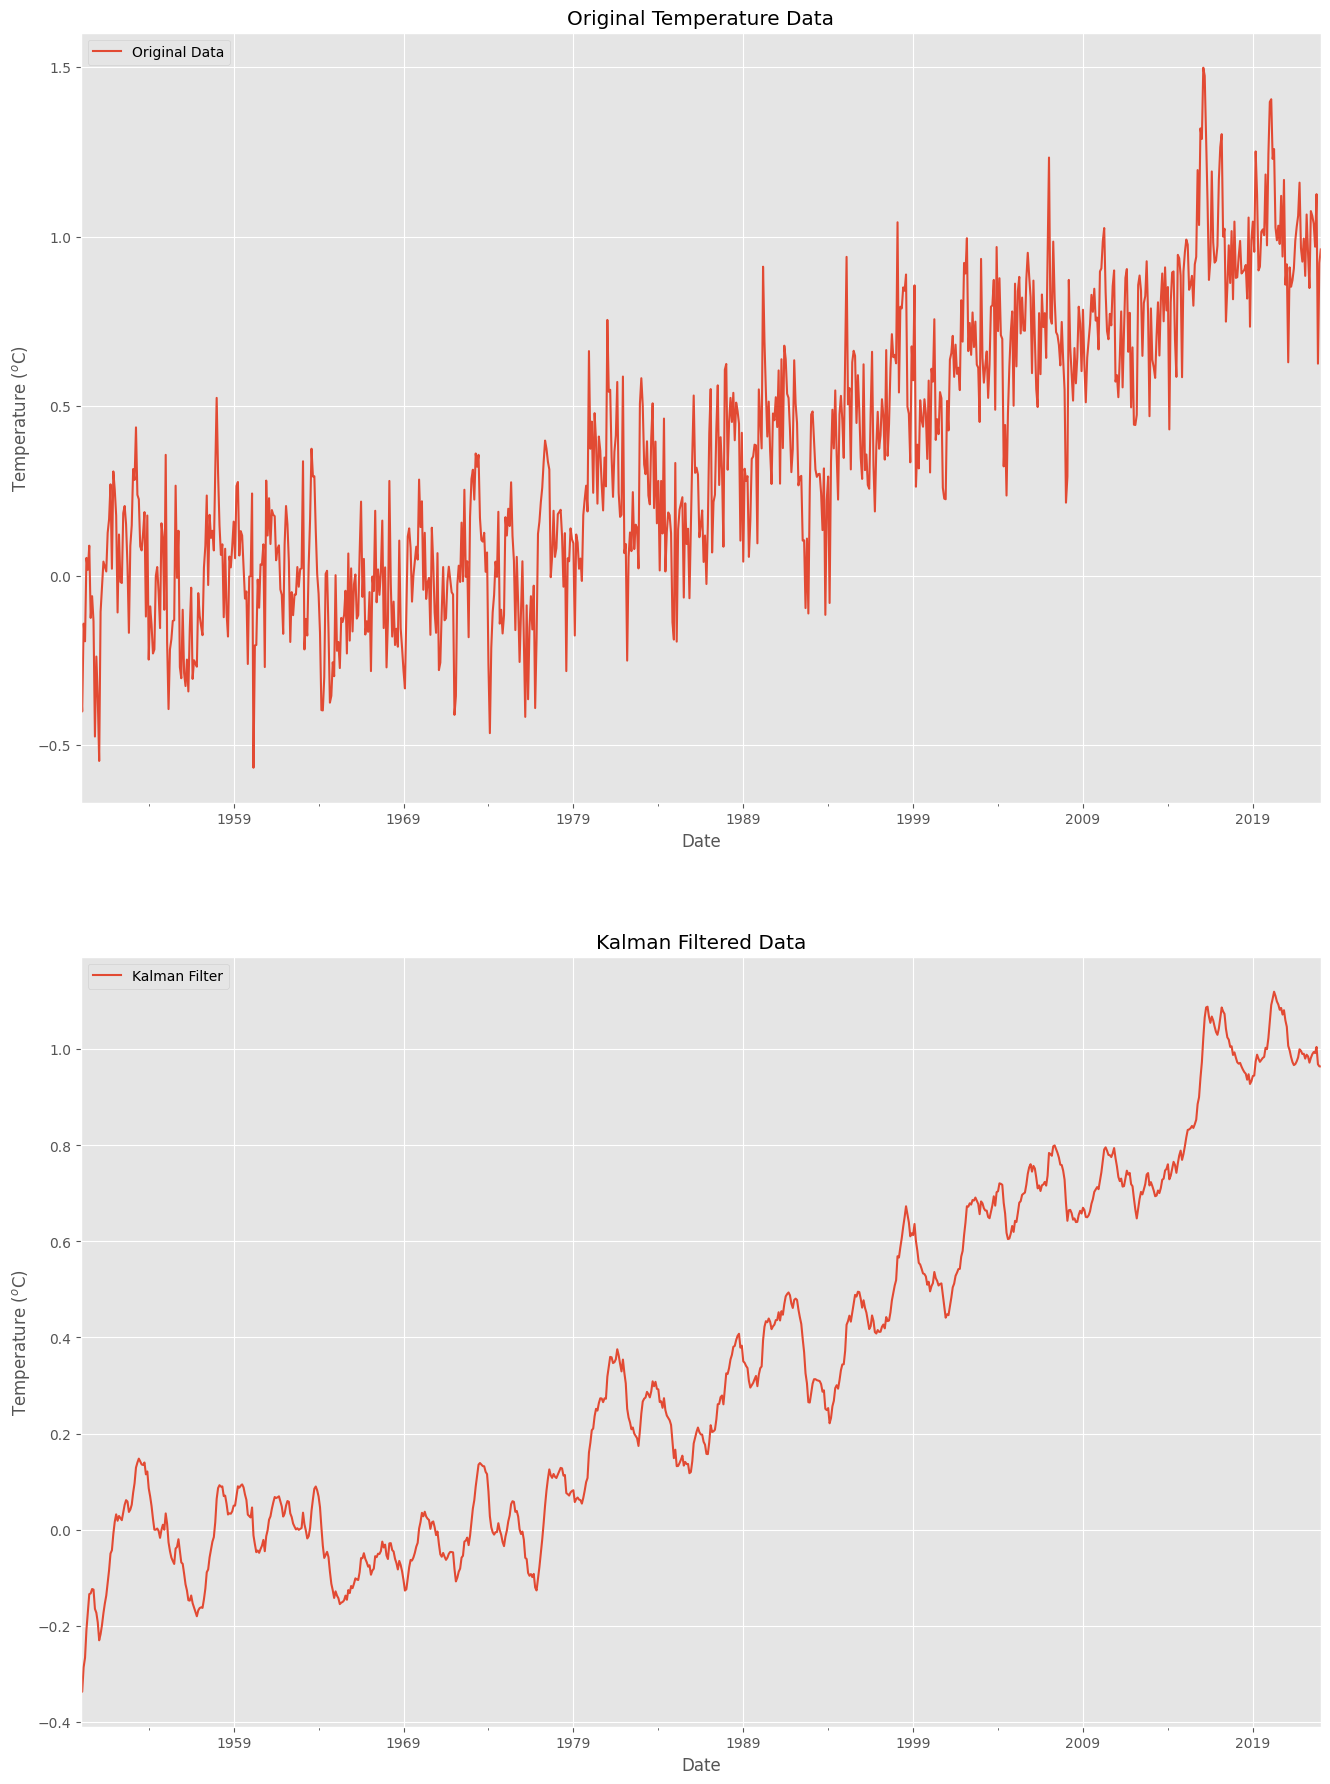

In [ ]:
plt.figure(figsize = (16, 22))

plt.subplot(2, 1, 1)
df_1950['Monthly Anomaly'].plot(label='Original Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Original Temperature Data')

plt.subplot(2, 1, 2)
df_1950['Kalman_filter'].plot(label='Kalman Filter')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Kalman Filtered Data')
plt.show()

## Kalman Smoothing

Unlike Kalman filtering, which focuses on predicting and updataing the current state using historical measurements, Kalman smmoothing increses the accuracy of past state values. This approach is particularly beneficial in scenarios that require a  comprehensive and accurate understandng of the entire data set. By effectively reducing the impact of noise and uncertainly, Kalman smoothing contributes to producing cleaner and more reliable data. The reveerse approach in Kalma smoothing involves revisiting and recalculating previous data points using infomation from past and future data. Ths approach allows for rechecking previous estimates with additional information that was not available during the initial estimation or prediction

Following are various components used in Kalman smoother that hel define the pattern of the series:

- Level : This component assumes that the time series has a consistent level or mean over time, which helps filter out random noise.

- Trend Level: In addition to the average over time, this component helps capture whether the data is trending upward or downward over time.

- Seasonal Level : Helps capture repetititve patters of avaraging over time, which captures periodic flctuations in the data.

- Seasonal trend level: This a combination of level, trend and seasonality components

- Long Seasonal Level : Captures long-term patterns over multiple season, which helps capture the periodic behavior of data of long duration


In [ ]:
from tsmoothie.smoother import KalmanSmoother

In [ ]:
#Lets apply kalman smoothing here
smoother = KalmanSmoother(component = 'level_trend', component_noise={'level':0.2, 'trend':0.1}, observation_noise=0.2)
smoother.smooth(df_1950['Monthly Anomaly'])

#Generate intervals
low, up = smoother.get_intervals('kalman_interval')


In [ ]:
df_1950['Kalman_smoothing'] = smoother.smooth_data[0]

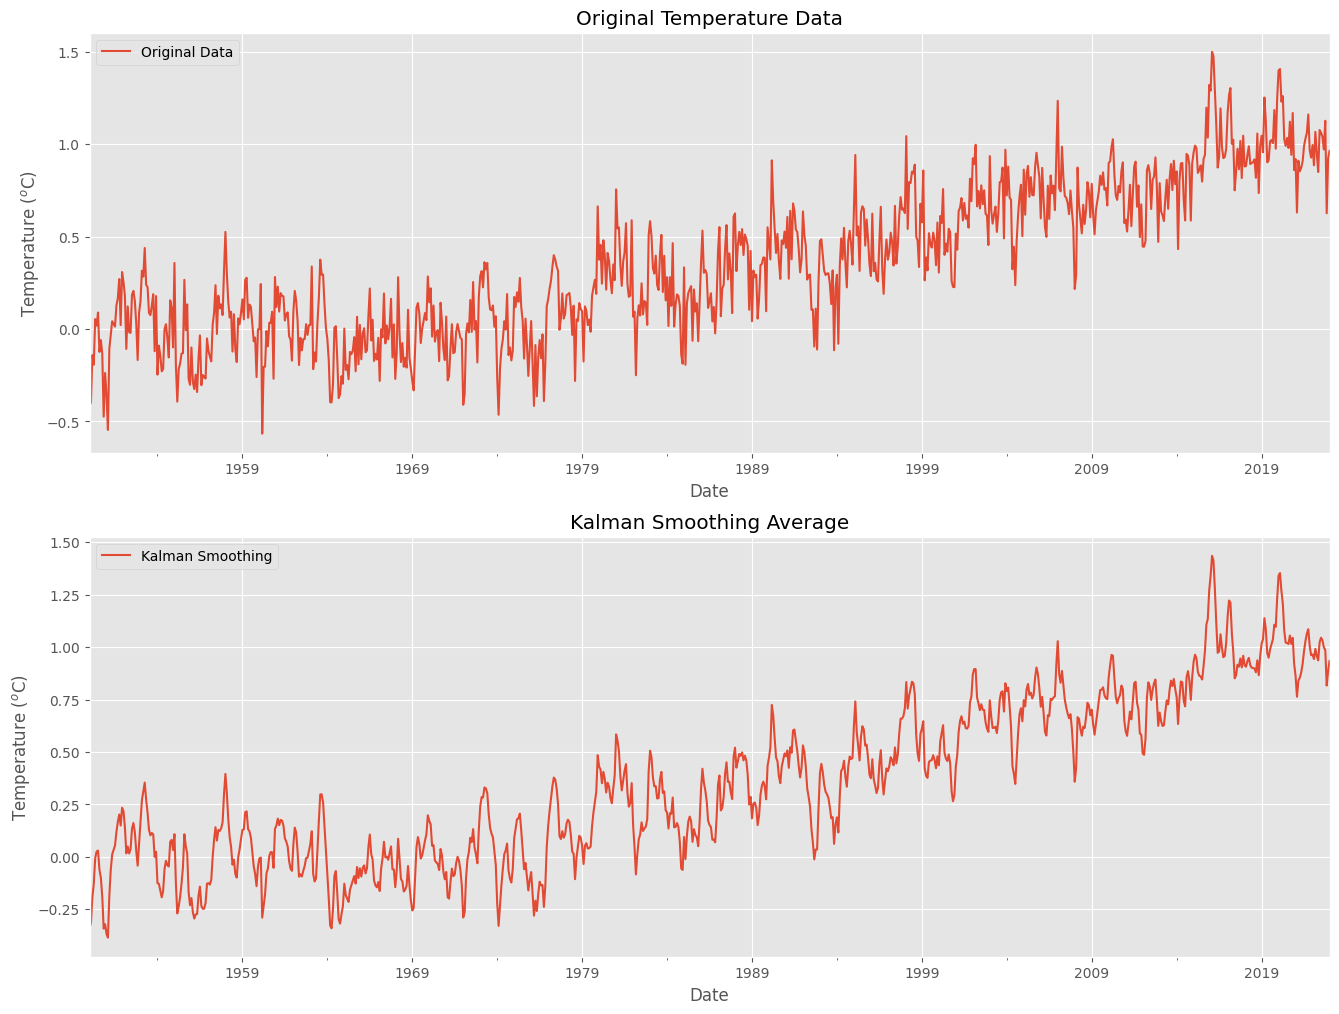

In [ ]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)
df_1950['Monthly Anomaly'].plot(label='Original Data')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Original Temperature Data')

plt.subplot(2, 1, 2)
df_1950['Kalman_smoothing'].plot(label='Kalman Smoothing')
plt.ylabel('Temperature ($^o$C)')
plt.legend(loc='upper left')
plt.title('Kalman Smoothing Average')
plt.show()



## Hodrick - Prescott filter

The Hondrock-Prescott Filter(HP Filter) is a statistical technique used to decompose a time series into two components: the long-term trend and the short-term fluctuations. It is named after its creators, Robert Hodrick and Edward Prescott

The idea behind the HP filter is to find a smoothed trend function that minimizes the varience of the fluctuaions with respect to the trend. This is a achived through a process of minimizing an objective function that takes into a account both the smoothness of the trend and the goodness of fit of the fluctuations.

Once the time series is decomposedd into trends and short-term fluctuations, analysts can analyze these components separetly, better understanding the long-term patterns and cyclcal variatons of the series. This can be useful for identfiying growth trends, economic cycles, turning points, and anomalies in the data.

It is a important to note thaht the HP Filter is not a perfect technique and has some limitations. The choice of the smoothing parameter can **affect** the results, and the interpretation of short-term fluctuations also requires caution, as they can be influenced by temporary factors or events not captured by the model;


In [ ]:
import statsmodels.api as sm
cicle, trend = sm.tsa.filters.hpfilter(df_1950['Monthly Anomaly'], 129600)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [ ]:
df_1950['Monthly Cicle Anomaly'] = cicle
df_1950['Monthly Trend Anomaly'] = trend

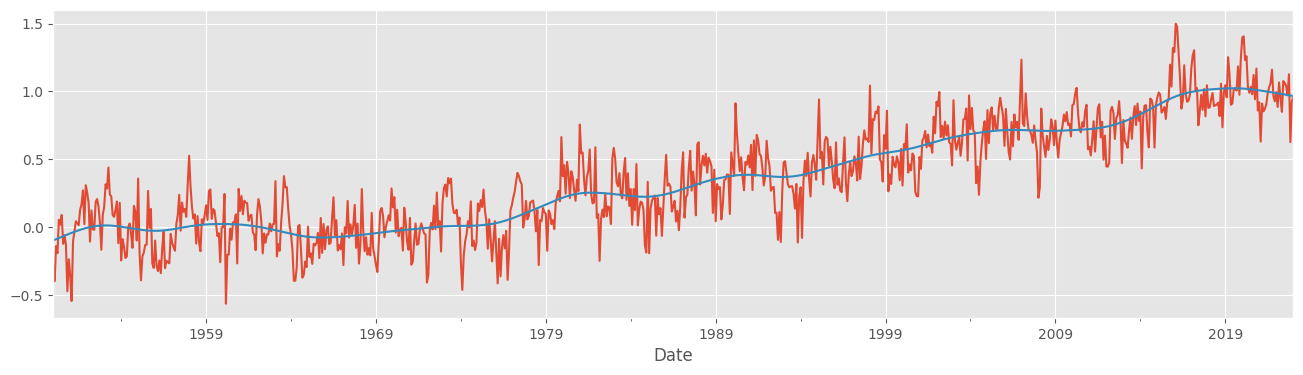

In [ ]:
plt.figure(figsize = (16,4))
df_1950['Monthly Anomaly'].plot()
df_1950['Monthly Trend Anomaly'].plot()
plt.show()

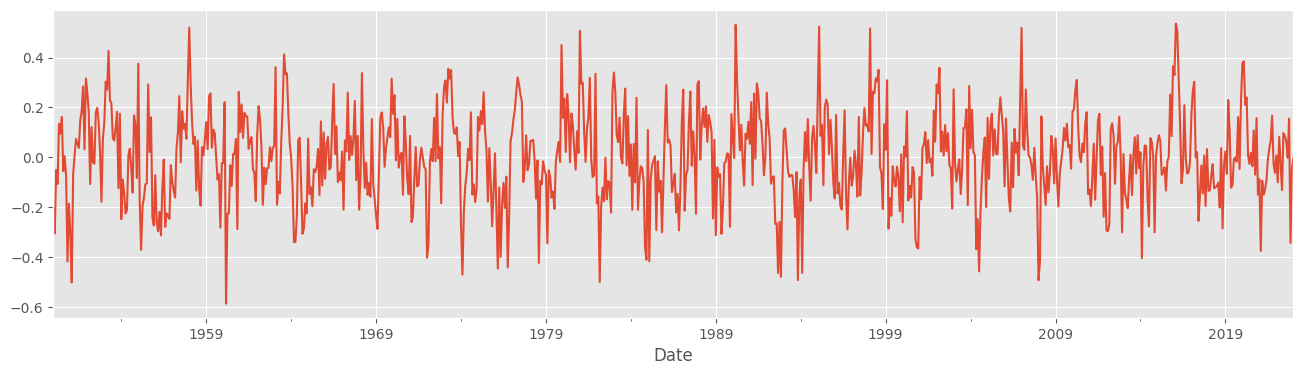

In [ ]:
plt.figure(figsize=(16, 4))
df_1950["Monthly Cicle Anomaly"].plot()
plt.show()

## Harmonic Models

Harmonic analysis of NDVI time series aims to characterize seasonal changes in the spectral behavior of targets by decomposing the time series into harmonic terms. Similar to principal component analysis, most of the variance in a dataset is contained in the first few terms (components). Over 90% of the variance in the original time series was captured in the additive and first two harmonic terms. The additive term and the phase and amplitude for the first two harmonic terms were extracted and used for further analysis.

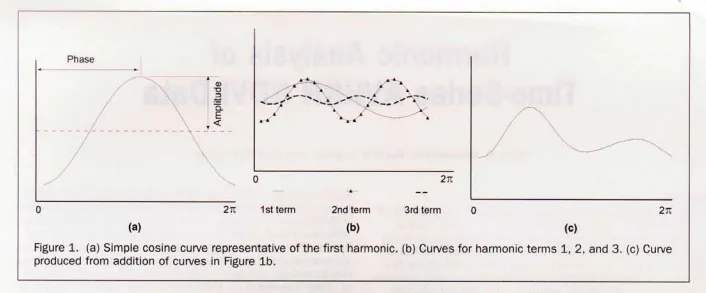

The amplitude corresponds to half the value at which the function is maximized, and the phase is the displacement between the origin and the peak of the wave in the interval from 0 to 2π. Each harmonic term represents the number of cycles completed by a wave, in a given time interval, and is responsible for a percentage of the total variance of the original time series. Thus, the first harmonic has a period T equal to the total period, the second harmonic corresponds to half the period of the first harmonic T/2, the third harmonic to T/3 and so on.


First, we will obtain NDVI data from areas with soybeans, where in each campaign, the NDVI has a harmonic pattern according to the phenological cycle of the crop:



In [ ]:
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geemap
import geopandas as gpd
import warnings
import datetime
warnings.filterwarnings('ignore')

In [ ]:
path_aoi_soja = '/content/drive/MyDrive/AlvaroSampaio/GeoScan/AOI_soja/AOI_SOJA.shp'
gdf_soja = gpd.read_file(path_aoi_soja)


In [ ]:
#Transformando nosso GeoDataFramme em um e
fc = geemap.geopandas_to_ee(gdf_soja)


In [ ]:
# Vamos pegas as medias mensais do ndvi das datas de 2017 ate 2024

S2_coll = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1)).filterDate('2017-01-01','2024-01-01').filterBounds(fc)

In [ ]:
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
  return image.addBands(ndvi)

S2_ndvi = S2_coll.map(addNDVI)

In [ ]:
def meanNDVI(image):
    image = ee.Image(image)
    meanDict = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDVI']),
        geometry = fc,
        scale = image.projection().nominalScale().getInfo(),
                                    maxPixels = 100000,
                                    bestEffort = True);
    return meanDict.get('NDVI').getInfo()

In [ ]:
listOfImages_ndvi = S2_ndvi.select('NDVI').toList(S2_ndvi.size())

ndvi_coll = []

for i in range(listOfImages_ndvi.length().getInfo()):
    image = ee.Image(listOfImages_ndvi.get(i-1))
    temp_ndvi = meanNDVI(image)
    ndvi_coll.append(temp_ndvi)

In [ ]:
#Convertendo num dataframe
dates = np.array(S2_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

In [ ]:
ndvi_df = pd.DataFrame(ndvi_coll, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index)
ndvi_df.sort_index(ascending = True, inplace = True)

ndvi_df.head(5)

ndvi
2019-05-09  0.165736
2019-05-19  0.807025
2019-05-19  0.783828
2019-06-08  0.807190
2019-06-23  0.596796

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the time series plot
sns.lineplot(data=ndvi_df, x=ndvi_df.index, y='ndvi')

# Set the title and axis labels
plt.title('NDVI Time Series')
plt.xlabel('Time')
plt.ylabel('NDVI')

# Display the plot
plt.show()


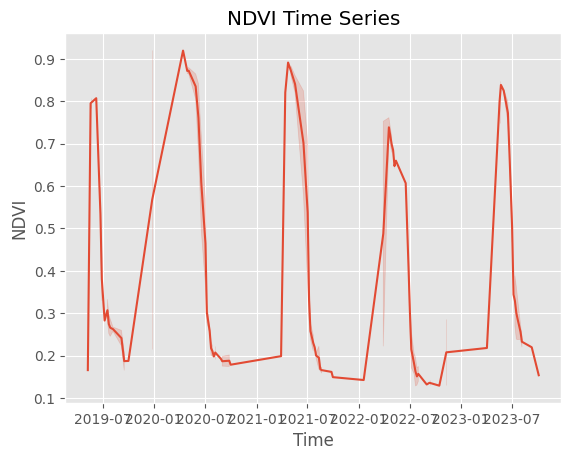

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the time series plot
sns.lineplot(data=ndvi_df, x=ndvi_df.index, y='ndvi')

# Set the title and axis labels
plt.title('NDVI Time Series')
plt.xlabel('Time')
plt.ylabel('NDVI')

# Display the plot
plt.show()


In [ ]:
#Aplicando a transformação harmonica
dependent = 'NDVI'
harmonics = 3
harmonicFrequencies = list(range(1, harmonics+1))

In [ ]:
harmonicFrequencies

[1, 2, 3]

In [ ]:
def getNames (base, lst_freq) :
  name_lst = []
  for i in lst_freq:
    name_lst.append(ee.String(base + str(i)))
  return name_lst

In [ ]:
cosNames = getNames('cos_', harmonicFrequencies);
sinNames = getNames('sin_', harmonicFrequencies);
independents = ee.List(['constant', 't']).cat(cosNames).cat(sinNames);

In [ ]:
def addConstant (image) :
  return image.addBands(ee.Image(1));

In [ ]:
import math
def addTime (image) :
  date = ee.Date(image.get('system:time_start'));
  years = date.difference(ee.Date('1970-01-01'), 'year');
  timeRadians = ee.Image(years.multiply(2 * math.pi));
  return image.addBands(timeRadians.rename('t').float());

In [ ]:
def addHarmonics (image) :
  frequencies = ee.Image.constant(harmonicFrequencies)
  time = ee.Image(image).select('t')
  cosines = time.multiply(frequencies).cos().rename(cosNames)
  sines = time.multiply(frequencies).sin().rename(sinNames)
  return image.addBands(cosines).addBands(sines)

In [ ]:
#Aplicando as funcções criadas na coleção de imagens
harmonicNDVI = S2_ndvi.map(addConstant).map(addTime).map(addHarmonics);
harmonicTrend = harmonicNDVI.select(independents.add(dependent)).reduce(ee.Reducer.linearRegression(independents.length(), 1))
harmonicTrendCoefficients = harmonicTrend.select('coefficients').arrayProject([0]).arrayFlatten([independents]);
fittedHarmonic = harmonicNDVI.map(lambda image : image.addBands(image.select(independents).multiply(harmonicTrendCoefficients).reduce('sum').rename('fitted')));
print(fittedHarmonic.getInfo())
print(harmonicTrendCoefficients.getInfo())

{'type': 'ImageCollection', 'bands': [], 'version': 1754763799211245, 'id': 'COPERNICUS/S2_SR_HARMONIZED', 'properties': {'date_range': [1490659200000, 1647907200000], 'period': 0, 'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['copernicus', 'esa', 'eu', 'msi', 'reflectance', 'sentinel', 'sr'], 'system:visualization_0_bands': 'B4,B3,B2', 'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png', 'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands representing SR scaled by 10000 (unl

In [ ]:
def fitted_harmonic_to_df(fitted_harmonic_coll):

  fitted_values_list = []
  dates_list = []

  for i in range(fitted_harmonic_coll.size().getInfo()):
    image = ee.Image(fitted_harmonic_coll.toList(fitted_harmonic_coll.size()).get(i))
    fitted_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=fc,  # Assuming 'fc' is your region of interest
        scale=30,
        maxPixels=1e13
    ).get('fitted').getInfo()
    date = image.date().format('YYYY-MM-dd').getInfo()

    fitted_values_list.append(fitted_value)
    dates_list.append(date)


  df = pd.DataFrame({'fitted': fitted_values_list}, index=pd.to_datetime(dates_list))
  return df


# Example usage:
fitted_df = fitted_harmonic_to_df(fittedHarmonic)
fitted_df


fitted
2019-05-09  0.370493
2019-05-19  0.345088
2019-05-19  0.345088
2019-06-08  0.261273
2019-06-23  0.197078
...              ...
2023-08-01  0.124218
2023-08-06  0.123245
2023-08-06  0.123245
2023-09-10  0.114466
2023-10-05  0.107687

[143 rows x 1 columns]

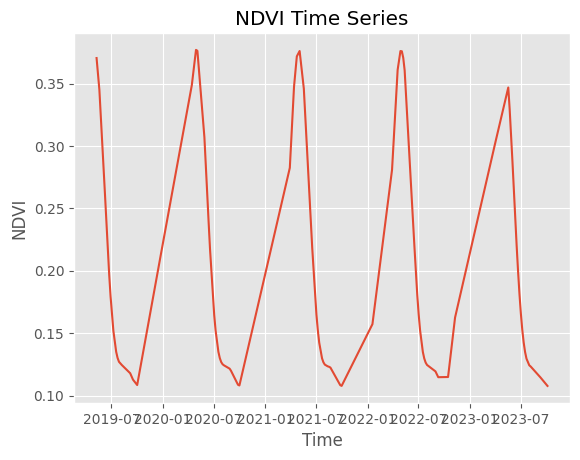

In [ ]:
sns.lineplot(data=fitted_df, x=fitted_df.index, y='fitted')

# Set the title and axis labels
plt.title('NDVI Time Series')
plt.xlabel('Time')
plt.ylabel('NDVI')

# Display the plot
plt.show()